Found 7697 images belonging to 355 classes.
Found 3560 images belonging to 355 classes.
83683744/83683744 [==============================] - 9s 0us/step
Epoch 1/750
240/240 [==============================] - 142s 583ms/step - loss: 5.0492 - accuracy: 0.1365 - val_loss: 3.7453 - val_accuracy: 0.3350
Epoch 2/750
240/240 [==============================] - 133s 554ms/step - loss: 2.8137 - accuracy: 0.4013 - val_loss: 2.2385 - val_accuracy: 0.4541
Epoch 3/750
240/240 [==============================] - 135s 561ms/step - loss: 1.8970 - accuracy: 0.5216 - val_loss: 1.8371 - val_accuracy: 0.5222
Epoch 4/750
240/240 [==============================] - 134s 560ms/step - loss: 1.5759 - accuracy: 0.5717 - val_loss: 1.7133 - val_accuracy: 0.5363
Epoch 5/750
240/240 [==============================] - 136s 568ms/step - loss: 1.4058 - accuracy: 0.6132 - val_loss: 1.6368 - val_accuracy: 0.5498
Epoch 6/750
240/240 [==============================] - 132s 551ms/step - loss: 1.2841 - accuracy: 0.6382 - val_l

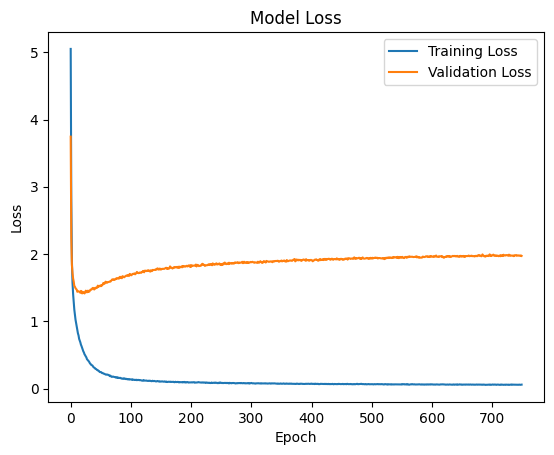

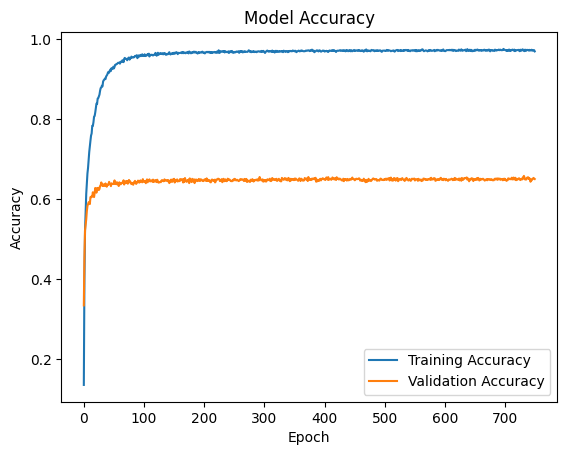

112/112 [==============================] - 20s 173ms/step
Accuracy (%): 65.0561797752809
Average Precision (%): 65.73434097059229
Average Recall (%): 64.92580736946934
Average F1 Score (%): 64.0667453838001


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from sklearn.metrics import confusion_matrix
from tensorflow.keras.applications import Xception

# Define data directories
train_data_dir = r"C:\Users\79894\Downloads\archive2_converted_train"
test_data_dir = r"C:\Users\79894\Downloads\archive2_converted_test"

# Define data generators with preprocessing_function (fixed image size)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)
test_datagen = ImageDataGenerator(rescale=1./255)

# Generate batches of preprocessed images
batch_size = 32
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(299, 299),  # Adjusted to match the Xception model input shape
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(299, 299),  # Adjusted to match the Xception model input shape
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Load pre-trained Xception model without the top classification layer
base_model = Xception(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Add custom layers on top of Xception
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(355, activation='softmax')(x)  # Adjust output neurons based on your classification task

# Combine base model and custom layers
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=SGD(learning_rate=1e-2, momentum=0.9, nesterov=True),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train your model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=750,  # Adjust as needed
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)

# Extract results from the final epoch
final_epoch_results = {
    'loss': history.history['loss'][-1],
    'accuracy': history.history['accuracy'][-1],
    'val_loss': history.history['val_loss'][-1],
    'val_accuracy': history.history['val_accuracy'][-1]
}

# Print the final epoch results
print("Final Epoch Results:")
print(final_epoch_results)

# Plot training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Plot accuracy history
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Evaluate the model on test data
validation_generator.reset()  # Reset the generator to start from the beginning
predictions = model.predict(validation_generator, steps=validation_generator.samples // batch_size + 1)
predicted_classes = np.argmax(predictions, axis=1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(validation_generator.classes, predicted_classes)

# Calculate metrics
accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)

precision = []
recall = []
f1_score = []

for i in range(355):  # Adjusted based on the number of classes
    true_positives = conf_matrix[i, i]
    false_positives = np.sum(conf_matrix[:, i]) - true_positives
    false_negatives = np.sum(conf_matrix[i, :]) - true_positives

    precision_i = true_positives / (true_positives + false_positives) if true_positives + false_positives != 0 else 0
    recall_i = true_positives / (true_positives + false_negatives) if true_positives + false_negatives != 0 else 0

    precision.append(precision_i)
    recall.append(recall_i)

    # Calculate F1 score
    if precision_i + recall_i != 0:
        f1_score_i = 2 * (precision_i * recall_i) / (precision_i + recall_i)
    else:
        f1_score_i = 0

    f1_score.append(f1_score_i)

# Calculate average precision, recall, and F1 score
avg_precision = np.mean(precision)
avg_recall = np.mean(recall)
avg_f1_score = np.mean(f1_score)

# Convert metrics to percentage format
accuracy_percentage = accuracy * 100
avg_precision_percentage = avg_precision * 100
avg_recall_percentage = avg_recall * 100
avg_f1_score_percentage = avg_f1_score * 100

# Print the metrics in percentage format
print("Accuracy (%):", accuracy_percentage)
print("Average Precision (%):", avg_precision_percentage)
print("Average Recall (%):", avg_recall_percentage)
print("Average F1 Score (%):", avg_f1_score_percentage)
